# "EDA and Prediction of Real Estate Sale Price using Select ML Algorithms on Kaggle"

- toc: true
- badges: true

## Introduction

In this notebook, we'll work on the [Ames Housing Dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) available on Kaggle as an educational competition. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the competition challenges us to predict the final price of each home. The competition dataset was compiled by Dean De Cock and it is an incredible alternative as a modernized and expanded version of the often cited Boston Housing dataset. 

Our work will be to make predictions on the `SalePrice` of the houses in the dataset. We will train ML algorithms on the train dataset given by the competition and then make submissions on the predictions of `SalePrice` of houses in the test dataset. Our submissions will be evaluated by rmsle, and we'll try to improve on this metric with each of our submission.

## Setup

First, we'll import the required libraries and get the file paths

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from sklearn.preprocessing import OneHotEncoder, Normalizer, RobustScaler # data preparation
from sklearn.impute import SimpleImputer # missing value handling
from sklearn.model_selection import KFold, cross_val_score # model selection
from sklearn.metrics import mean_squared_error # metrics
from scipy.stats import norm, skew # statistics
import psutil # get cpu core count
from bayes_opt import BayesianOptimization # hyperparameter tuning

# pipelines
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline 

# ML models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# get file paths
import os
data_dir = os.getcwd()
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename[-4:] == '.csv':
            print(os.path.join(dirname, filename))

C:\Users\ncits\Downloads\Ames Housing\sample_submission.csv
C:\Users\ncits\Downloads\Ames Housing\test.csv
C:\Users\ncits\Downloads\Ames Housing\train.csv


All data files are under 1MB and safe to import wholly.

In [10]:

# import files
train = pd.read_csv(data_dir + "/train.csv", index_col = ["Id"])
test = pd.read_csv(data_dir + "/test.csv", index_col = ["Id"])
submission_df = pd.read_csv(data_dir + "/sample_submission.csv")

In [11]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<font size="2"> <b>Observations</b></font>

- data contains both numeric and categorical features.
- `SalePrice` is the target column

In [12]:

# random state seed
seed = 42

In [13]:

# Separate target from features
X_train = train.copy()
y_train = X_train.pop("SalePrice")

## EDA and Data Preparation

Now, we'll perform some basic data analysis and we'll use the insights we'll get to prepare the data for ML training.

### Preliminary Analysis

In [14]:
pd.set_option("display.max_columns", None)
X_train.head(15)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

<font size="2"> <b>Observations</b></font>

- There are 1460 entries with 79 features. 
- Some features have null values, and thus will need further inspection.
- Some features can be accumulated to give new features. For eg. totalling different types of rooms to give a feature `total_rooms`. 

### Null Values

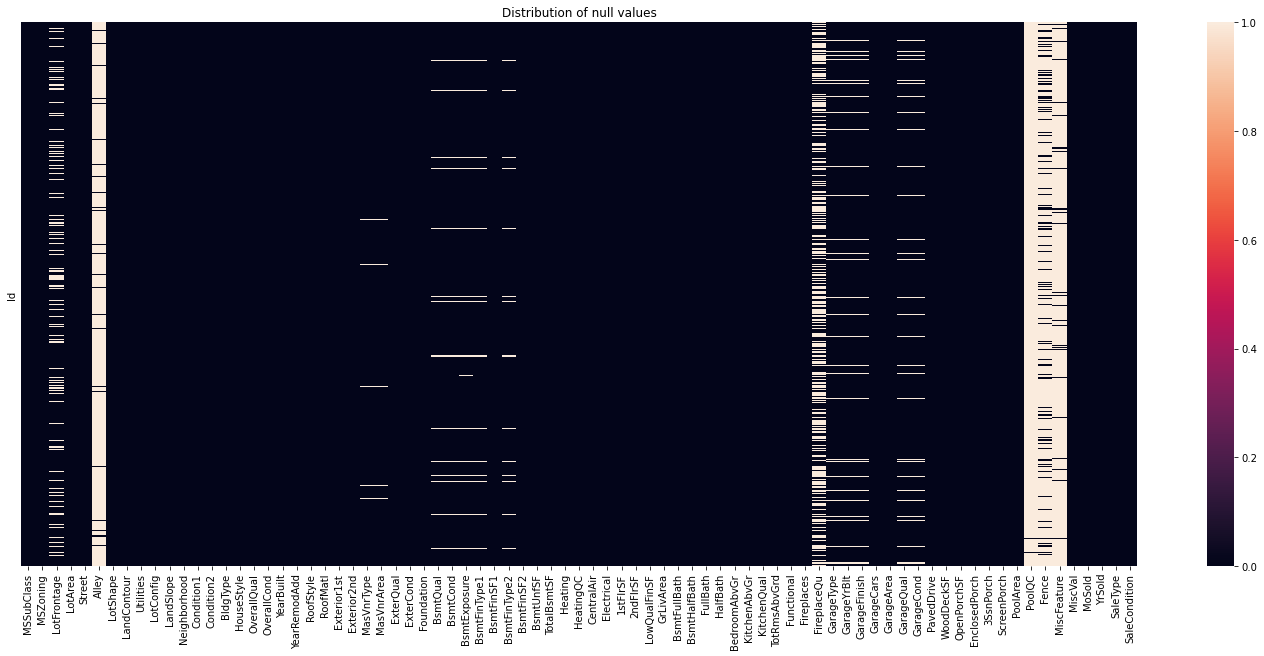

In [16]:

# distribution of null values
plt.figure(figsize = (25, 10))
sns.heatmap(X_train.isnull(), yticklabels = "")
plt.title("Distribution of null values")
plt.show()

In [17]:

# count of null values
null_count = X_train.isnull().sum()
null_count = null_count.to_frame(name = "null_values")[null_count > 0]
null_count["null_percentage"] = null_count["null_values"]/len(X_train)*100
null_vals = null_count.sort_values(by = ["null_values"], ascending = False)

null_vals

,null_values,null_percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


**Observations**

- `PoolQC`, `MiscFeature`, `Alley` and `Fence` have a lot of null values. 
- Fortunately, the [data description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) tells us that in all of the categorical feature columns bar one, null values indicate absence of those feature condition in the entries. Therefore, we'll impute null values in these feaure columns with 'None'.
- `Electrical` is the only feature column where null values don't indicate absence of any condition. But because there is only 1 null entry, we can drop this entry. 
- With regards to numerical columns, `MasVnrArea` and `LotFrontage` can be filled with 0 because here too, null values indicate absence of the conditions. `GarageYrBlt` can be filled with the median value, because although it is linked with the `GarageCond` column, absence of garage cannot have year 0 in `GarageYrBlt`.
- For newer null value columns in the test dataset, we'll choose to impute them with either `most_frequent`(Categorical) or `median`(Numeric). 

In [18]:

# column dtypes
X_train.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

### Handle Null values

In [19]:
null_cols = null_vals.index
null_cols = null_cols.drop("Electrical")


# drop null from `Electrical`
def drop_electrical_null(X, y):
    drop_idx = X[X["Electrical"].isnull()].index
    X = X.drop(drop_idx)
    y = y.drop(drop_idx)
    
    return X, y


# categorical columns
X_train['MSSubClass'] = X_train['MSSubClass'].apply(str)

cat_cols = X_train.select_dtypes(include = ["object"]).columns

cat_null_cols = null_cols.intersection(cat_cols)
cat_null_cols_imp = SimpleImputer(strategy = "constant", fill_value = "None")

cat_not_null_cols = cat_cols.difference(cat_null_cols)
cat_not_null_coll_imp = SimpleImputer(strategy = "most_frequent")

cat_null_ct = make_column_transformer((cat_null_cols_imp, cat_null_cols), (cat_not_null_coll_imp, cat_not_null_cols))


# numeric columns
num_cols = X_train.select_dtypes(exclude = ["object"]).columns

num_null0_cols = pd.Index(["MasVnrArea", "LotFrontage"])
num_null0_cols_imp = SimpleImputer(strategy = "constant", fill_value = 0)

num_not_null_cols = num_cols.difference(num_null0_cols)
num_not_null_cols_imp = SimpleImputer(strategy = "median")

num_null_ct = make_column_transformer((num_null0_cols_imp, num_null0_cols), (num_not_null_cols_imp, num_not_null_cols))


# combine both into a common transformer
null_ct = make_column_transformer((cat_null_ct, cat_cols), (num_null_ct, num_cols))
null_ct_features_in = cat_null_cols.append(cat_not_null_cols).append(num_null0_cols).append(num_not_null_cols)

### Distribution and Outliers

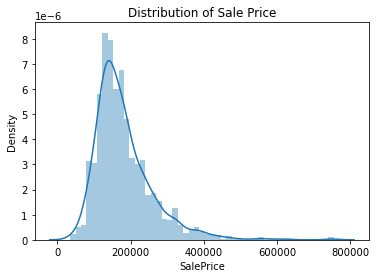

In [20]:

# SalePrice (target)
sns.distplot(y_train, kde = True)
plt.title("Distribution of Sale Price")
plt.show()

The target looks skewed. We'll normalise it.

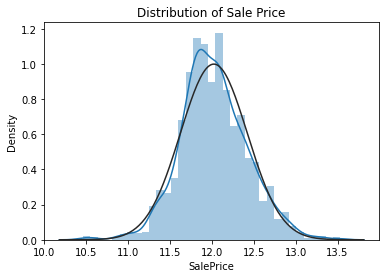

In [21]:

# normalized SalePrice (target)
y_train = np.log1p(y_train)
sns.distplot(y_train, fit = norm, kde = True)
plt.title("Distribution of Sale Price")
plt.show()

The target is normalized. Now, we can look at the numerical features.

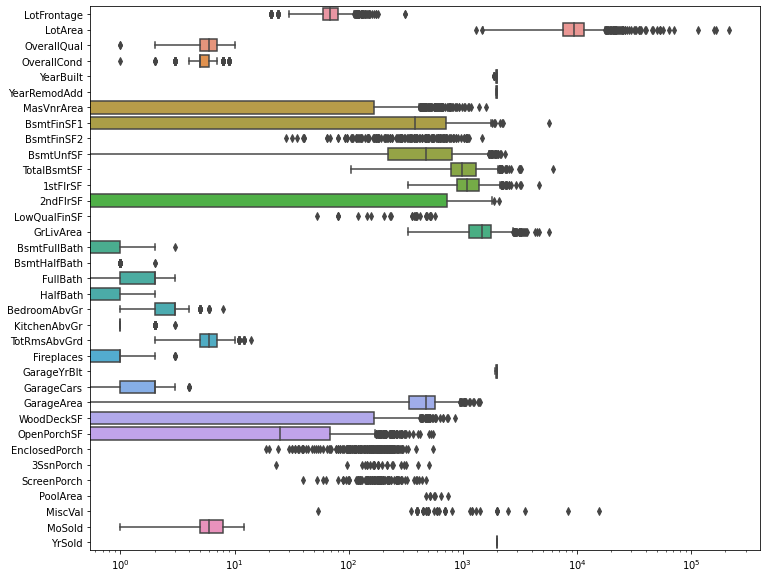

In [22]:
plt.figure(figsize = (12,10))
fig = sns.boxplot(data = X_train[num_cols], orient = 'h')
fig.set_xscale("log")

There are quite a few outliers in the numeric columns. We'll need to scale numeric data using `RobustScaler` in the preprocessor building section. Also, many of the numeric features are skewed and will need to be normalized so that we can train ML models which assume normality in the features. 

In [23]:

# features which deviate a lot from the normal curve
imputed_features = pd.DataFrame(num_null_ct.fit_transform(X_train[num_cols]))
num_features_in = num_null0_cols.append(num_not_null_cols)
imputed_features.columns = num_features_in

skew_features = imputed_features.apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features.loc[skew_features > 0.5]
skewed_index = high_skew.index
high_skew

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
dtype: float64

In [24]:

# normalize the skewed features
norma = Normalizer()

normalized_cols = pd.DataFrame(norma.fit_transform(imputed_features[skewed_index]))
normalized_cols.columns = skewed_index
normalized_cols.head()

,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,KitchenAbvGr,BsmtFinSF2,ScreenPorch,BsmtHalfBath,EnclosedPorch,MasVnrArea,OpenPorchSF,BsmtFinSF1,WoodDeckSF,TotalBsmtSF,1stFlrSF,GrLivArea,BsmtUnfSF,2ndFlrSF,OverallCond,TotRmsAbvGrd,HalfBath,Fireplaces,BsmtFullBath
0,0.0,0.0,0.962439,0.0,0.0,0.000114,0.0,0.0,0.000000,0.00000,0.022324,0.006948,0.080412,0.000000,0.097497,0.097497,0.194766,0.017085,0.097269,0.000569,0.000911,0.000114,0.000000,0.000114
1,0.0,0.0,0.969430,0.0,0.0,0.000101,0.0,0.0,0.000101,0.00000,0.000000,0.000000,0.098761,0.030093,0.127440,0.127440,0.127440,0.028679,0.000000,0.000808,0.000606,0.000000,0.000101,0.000000
2,0.0,0.0,0.976793,0.0,0.0,0.000087,0.0,0.0,0.000000,0.00000,0.014066,0.003647,0.042197,0.000000,0.079880,0.079880,0.155071,0.037683,0.075191,0.000434,0.000521,0.000087,0.000087,0.000087
3,0.0,0.0,0.971507,0.0,0.0,0.000102,0.0,0.0,0.000000,0.02767,0.000000,0.003560,0.021973,0.000000,0.076907,0.097761,0.174668,0.054933,0.076907,0.000509,0.000712,0.000000,0.000102,0.000102
4,0.0,0.0,0.977664,0.0,0.0,0.000069,0.0,0.0,0.000000,0.00000,0.023996,0.005759,0.044907,0.013163,0.078501,0.078501,0.150695,0.033594,0.072194,0.000343,0.000617,0.000069,0.000069,0.000069


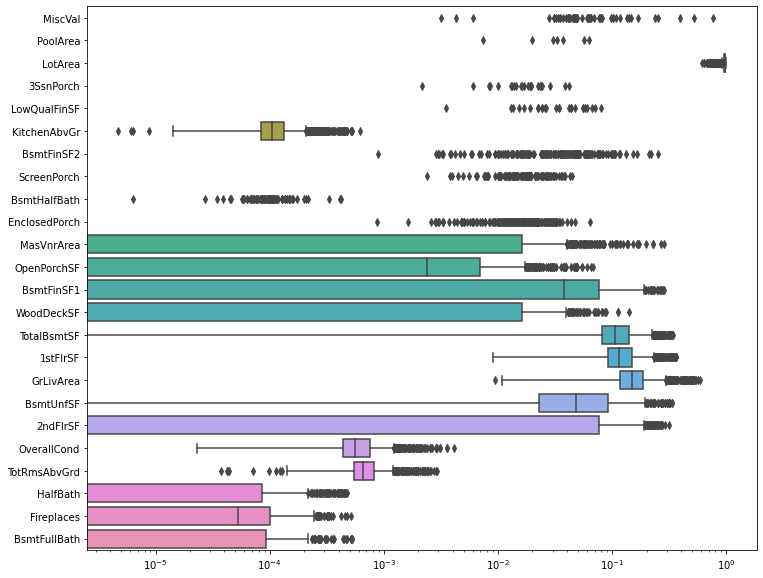

In [25]:
plt.figure(figsize = (12, 10))
fig = sns.boxplot(data = normalized_cols, orient = "h")
fig.set_xscale("log")

Some features like `MasVnrArea, OpenPorchSF, BsmtFinSF1, WoodDeckDF, 2ndFlrSF` couldn't be normalized. These columns will thus need to be dropped after extracting important information from them, which we'll do in the feature engineering section.

### Feature Engineering

Area related features are important in predicting sale price of houses, and thus we can engineer some features related to area. We can also add some binary features indicating presence of swimming pool, garage or fireplace, which also are an important determiners of real estate value.

In [26]:
def add_cols(df):
    
    # Add area related features
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                                  df['EnclosedPorch'] + df['ScreenPorch'] +
                                  df['WoodDeckSF'])
    
    # Add simplified categorical features
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    df[["haspool", "hasgarage", "hasbsmt", "hasfireplace"]] = df[["haspool", "hasgarage", "hasbsmt", "hasfireplace"]].astype("object")
    
    return df

### Prepare the data

Now, we will combine all we have learnt and done in the previous sections to process the data on which an ML algorithm can be trained. We'll 

- normalize target
- impute null values
- add features
- drop features
- onehotencode categorical features
- normalize skewed numeric features
- scale numeric features

In [27]:

# function to preprocess the data
def get_prepared_data(transform_numeric = True):
    X_trn = train.copy()
    y_trn = X_trn.pop("SalePrice")
    X_tst = test.copy()
    
    X_trn['MSSubClass'] = X_trn['MSSubClass'].astype("object")
    X_tst['MSSubClass'] = X_tst['MSSubClass'].astype("object")

    # normalize target
    y_trn = np.log1p(y_trn)
    
    # handle null values
    X_trn, y_trn = drop_electrical_null(X_trn, y_trn)
    X_trn = pd.DataFrame(null_ct.fit_transform(X_trn))
    X_tst = pd.DataFrame(null_ct.transform(X_tst))
    
    X_trn = X_trn.infer_objects()
    X_tst = X_tst.infer_objects()
    
    # re add column names
    X_trn.columns = null_ct_features_in
    X_tst.columns = null_ct_features_in
    
    X_trn['MSSubClass'] = X_trn['MSSubClass'].astype("object")
    X_tst['MSSubClass'] = X_tst['MSSubClass'].astype("object")
    
    # add features
    X_trn = add_cols(X_trn)
    X_tst = add_cols(X_tst)

    # drop features
    X_trn.drop(columns = ["MasVnrArea", "OpenPorchSF", "BsmtFinSF1", "WoodDeckSF", "2ndFlrSF"], inplace = True)
    X_tst.drop(columns = ["MasVnrArea", "OpenPorchSF", "BsmtFinSF1", "WoodDeckSF", "2ndFlrSF"], inplace = True)
    
    # categorical features
    cat_cols = X_trn.select_dtypes(include = ["object"]).columns
    cat_ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False, dtype = 'uint8')

    # normalize numeric features
    num_cols = X_trn.select_dtypes(exclude = ["object"]).columns
    num_pipe = make_pipeline(Normalizer(), RobustScaler())
    
    # column transformer
    if transform_numeric:
        ct = make_column_transformer((cat_ohe, cat_cols), (num_pipe, num_cols))
    else:
        ct = make_column_transformer((cat_ohe, cat_cols), remainder = "passthrough")
        
    X_trn = pd.DataFrame(ct.fit_transform(X_trn))
    X_tst = pd.DataFrame(ct.transform(X_tst))

    return X_trn, y_trn, X_tst

In [48]:

# get the processed data
X_trn, y_trn, X_tst = get_prepared_data(True)

Now, we can move on to ML model training.

## Train a Dummy model and Evaluate Performance

We'll train a dummy classifier to establish a baseline score. The future models should at least beat this scores. It helps to identify errors in training.

### Dummy Model

In [29]:

# define model
dummy_model = DummyRegressor()

In [66]:

# model evaluation
def evaluate_model(model, X_trn = X_trn):
    cvs = cross_val_score(model, X_trn, y_trn, scoring = "neg_root_mean_squared_error")

    rmsle = -cvs.mean()
    
    print(f"Model RMSLE: {rmsle:.5f}")
    
evaluate_model(dummy_model)

Model RMSLE: 0.39936


#### Make submission

In [32]:

# train model
dummy_model.fit(X_trn, y_trn)

# make predictions
dummy_preds = dummy_model.predict(X_tst)

In [67]:
-cross_val_score(dummy_model, X_trn, y_trn, scoring = "neg_root_mean_squared_error").mean()

0.3993601707158806

In [86]:

# create submission file
submission_df["SalePrice"] = dummy_preds
submission_df.to_csv("dummy_model.csv", index = None)

The submission gives use a score of 0.42578. The future ML models should at least beat the cv rmsle score of 0.39936 and submission rmsle score of 0.42578.

## Linear Models

First we'll train some linear models and compare their performance and make decision on training a final one.

In [88]:

# cv splitter
k_folds = KFold(5, shuffle = True, random_state = seed)

# parameters for cv
e_alphas = np.arange(0.0001, 0.0007, 0.0001)
e_l1ratio = np.arange(0.8, 1, 0.05)
alphas_ridge = np.arange(10, 16, 0.5)
alphas_lasso = np.arange(0.0001, 0.0008, 0.0001)

In [89]:

# linear models
ridge = RidgeCV(alphas = alphas_ridge, scoring = "neg_mean_squared_error", cv = k_folds)
lasso = LassoCV(alphas = alphas_lasso, max_iter = 1e6, cv = k_folds, n_jobs = -1, random_state = seed)
elastic_net = ElasticNetCV(l1_ratio = e_l1ratio, alphas = e_alphas, max_iter = 1e6, cv = k_folds, n_jobs = -1, random_state = seed)

models = {"Ridge": ridge,
         "Lasso": lasso, 
         "ElasticNet": elastic_net}

In [92]:

# compare linear models
scores = {}

for model_name, model in models.items():
    
    print(f"{model_name}:")   
    score = np.sqrt(-cross_val_score(model, X_trn, y_trn, scoring = "neg_mean_squared_error", cv = k_folds))
    print(score)
    print(f"RMSLE mean: {score.mean():.5f} \nRMSLE std: {score.std():.5f}")
    print("-" * 50)
    
    scores[model_name] = (score.mean(), score.std())
    

Ridge:
[0.13595902 0.15096778 0.13826833 0.13605681 0.12490943]
RMSLE mean: 0.13723 
RMSLE std: 0.00830
--------------------------------------------------
Lasso:
[0.13737072 0.15284838 0.13888969 0.13586582 0.12556263]
RMSLE mean: 0.13811 
RMSLE std: 0.00873
--------------------------------------------------
ElasticNet:
[0.13721347 0.15238829 0.13744699 0.13594653 0.12550764]
RMSLE mean: 0.13770 
RMSLE std: 0.00858
--------------------------------------------------


All these scores are improvements over baseline score and achieve rmsle scores in the range of 0.12-0.15. We can get a better score by blending all these linear models. Blending makes theses models complement each other and reduce their individual overfits. 

### Blended Model

In [93]:
%%time

print("training started...")

# train all models
ridge.fit(X_trn, y_trn)
lasso.fit(X_trn, y_trn)
elastic_net.fit(X_trn, y_trn)

print("training complete")

training started...
training complete
CPU times: total: 8.7 s
Wall time: 2.62 s


#### Make Submission

In [94]:

# make predictions
blended_preds = (ridge.predict(X_tst) + lasso.predict(X_tst) + elastic_net.predict(X_tst))/3
blended_preds = np.expm1(blended_preds)

In [96]:

# create submission file
submission_df["SalePrice"] = blended_preds
submission_df.to_csv("blended_linear.csv", index = None)

This submission from blended linear models give us a rmsle score of 0.13819 which is similar to the performance of a single lasso model. But we can improve more on this score by using gradient boosting trees, which we'll do in the next section.

## Gradient Boosting Models

In this section, first we'll train a lightgbm model and then we'll train an xgboost model. Normalizing and scaling that we applied on numeric features earlier deteriorates the performance of gradient boosting trees, which can actually use the information lost through transformation. Therefore, To train these models, we'll reload the processed data, this time without transforming the numeric features. 


In [100]:

# load processed data
X_trn, y_trn, X_tst = get_prepared_data(False)

### LightGBM - Train and Evaluate

In [102]:

# get cpu core count
core_count = psutil.cpu_count(logical = False)
core_count

4

In [107]:

# lightgbm parameters
param = {"bagging_fraction": 0.8,
        "bagging_freq": 2, 
        "learning_rate": 0.01,
        "num_leaves": 10,
        "max_depth": 5,
        "min_data_in_leaf": 10,
        "metric": "rmse",
        "num_threads": core_count,
        "verbosity": -1}

In [127]:
#collapse_output

# train and evaluate lightgbm
val_scores = []
i = 1

for trn_idx, val_idx in k_folds.split(X_trn, y_trn):

    print(f"Split {i}:")
    
    trn = lgb.Dataset(X_trn.iloc[trn_idx], y_trn.iloc[trn_idx])
    val = lgb.Dataset(X_trn.iloc[val_idx], y_trn.iloc[val_idx])
    
    bst = lgb.train(param, trn, num_boost_round = 3000, valid_sets = [trn, val], early_stopping_rounds = 10, verbose_eval = 50)
    
    score = bst.best_score["valid_1"]["rmse"]
    val_scores.append(score)
    
    print(f"RMSLE: {score:.5f}")
    print("-" * 65)
    
    i += 1

Split 1:
Training until validation scores don't improve for 10 rounds
[50]	training's rmse: 0.2779	valid_1's rmse: 0.294501
[100]	training's rmse: 0.208419	valid_1's rmse: 0.22513
[150]	training's rmse: 0.168045	valid_1's rmse: 0.186805
[200]	training's rmse: 0.143163	valid_1's rmse: 0.164704
[250]	training's rmse: 0.126932	valid_1's rmse: 0.151274
[300]	training's rmse: 0.115682	valid_1's rmse: 0.14419
[350]	training's rmse: 0.10737	valid_1's rmse: 0.139166
[400]	training's rmse: 0.101333	valid_1's rmse: 0.135577
[450]	training's rmse: 0.0965005	valid_1's rmse: 0.133299
[500]	training's rmse: 0.0926217	valid_1's rmse: 0.131744
[550]	training's rmse: 0.0891204	valid_1's rmse: 0.130774
[600]	training's rmse: 0.0863924	valid_1's rmse: 0.12962
[650]	training's rmse: 0.0838749	valid_1's rmse: 0.129178
Early stopping, best iteration is:
[644]	training's rmse: 0.0840888	valid_1's rmse: 0.129117
RMSLE: 0.12912
-----------------------------------------------------------------
Split 2:
Training

In [109]:

# Avg RMSLE
np.mean(val_scores)

0.13382349293051415

Even without hyperparameter tuning, the validation scores are better than those of linear models. Now, we'll train on the whole dataset and make a submission.

In [113]:
trn = lgb.Dataset(X_trn, y_trn)

lgb_cv = lgb.cv(param, trn, num_boost_round = 3000, folds = k_folds, early_stopping_rounds = 10)

lgb_cv["rmse-mean"][-1]

0.13197370164429242

In [46]:

# train on full data
bst = lgb.train(param, trn, num_boost_round = len(lgb_cv["rmse-mean"]))

# make predictions
lgb_preds = np.expm1(bst.predict(X_tst))

#### Make submission

In [47]:
submission_df["SalePrice"] = lgb_preds

submission_df.to_csv("lgb.csv", index = None)

This submission gives us a score of 0.12901, which is an improvement over the last submission. Now, we can further optimize it with hyperparameter tuning.

### LightGBM - Hyperparameter tuning

We'll use Bayesian Optimization to tune the hyperparameters in this section and then we'll make a submssion. 

In [146]:

# black box function for Bayesian Optimization
def LGB_bayesian(bagging_fraction,
                bagging_freq,
                lambda_l1,
                lambda_l2,
                learning_rate,
                max_depth,
                min_data_in_leaf,
                min_gain_to_split,
                min_sum_hessian_in_leaf,  
                num_leaves,
                feature_fraction):
    
    # LightGBM expects these parameters to be integer. So we make them integer
    bagging_freq = int(bagging_freq)
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    
    # parameters
    param = {'bagging_fraction': bagging_fraction,
            'bagging_freq': bagging_freq,
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'min_data_in_leaf': min_data_in_leaf,
            'min_gain_to_split': min_gain_to_split,
            'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
            'num_leaves': num_leaves,
            'feature_fraction': feature_fraction,
            'seed': seed,
            'feature_fraction_seed': seed,
            'bagging_seed': seed,
            'drop_seed': seed,
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'verbosity': -1,
            'num_threads': core_count}
    
    trn = lgb.Dataset(X_trn, y_trn)
    
    lgb_cv = lgb.cv(param, trn, num_boost_round = 1500, folds = k_folds, stratified = False, early_stopping_rounds = 10, seed = seed)
    score = lgb_cv["rmse-mean"][-1]
    
    return 1/score

In [147]:

# parameter bounds
bounds_LGB = {
    'bagging_fraction': (0.5, 1),
    'bagging_freq': (1, 4),
    'lambda_l1': (0, 3.0), 
    'lambda_l2': (0, 3.0), 
    'learning_rate': (0.005, 0.3),
    'max_depth':(3,8),
    'min_data_in_leaf': (5, 20),  
    'min_gain_to_split': (0, 1),
    'min_sum_hessian_in_leaf': (0.01, 20),    
    'num_leaves': (5, 20),
    'feature_fraction': (0.05, 1)
}

In [148]:

# optimizer
LG_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state = seed)

In [149]:
#collapse_output

# find the best hyperparameters
LG_BO.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  6.338    |  0.6873   |  3.852    |  0.7454   |  1.796    |  0.4681   |  0.05102  |  3.29     |  17.99    |  0.6011   |  14.16    |  5.309    |
|  2        |  6.913    |  0.985    |  3.497    |  0.2517   |  0.5455   |  0.5502   |  0.09475  |  5.624    |  11.48    |  0.2912   |  12.24    |  7.092    |
|  3        |  6.262    |  0.6461   |  2.099    |  0.4833   |  2.356    |  0.599    |  0.1567   |  5.962    |  5.697    |  0.6075   |  3.419    |  5.976    |
|  4        |  6.481    |  0.9744   |  3.897    |  0.818    |  0.9138   |  0.293    |  0.2068   |  5.201    |  6.831    |  0.4952   |  0.6974   |  18.64    |
|  5        |  6.091    |  0.6294   |  2.988    |  0

|  31       |  6.112    |  0.5      |  3.916    |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  20.0     |  1.0      |  5.31     |  5.0      |
|  32       |  7.713    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  20.0     |  0.0      |  4.486    |  9.099    |
|  33       |  7.736    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  20.0     |  0.0      |  0.4313   |  8.136    |
|  34       |  7.696    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  4.89     |  20.0     |  0.0      |  2.015    |  7.902    |
|  35       |  6.966    |  0.5      |  1.0      |  1.0      |  3.0      |  0.0      |  0.005    |  7.259    |  20.0     |  0.0      |  1.833    |  7.665    |
|  36       |  7.658    |  0.5      |  1.0      |  1.0      |  0.0      |  2.869    |  0.005    |  6.494    |  20.0     |  0.0      |  0.01     |  6.427    |
|  37       |  7.51     |  1.0      |  1.0      |  1

|  63       |  7.122    |  0.5      |  1.0      |  0.05     |  0.0      |  3.0      |  0.3      |  3.0      |  15.63    |  0.0      |  0.01     |  20.0     |
|  64       |  7.759    |  0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  13.28    |  0.0      |  0.01     |  14.36    |
|  65       |  6.188    |  0.5      |  1.0      |  0.05     |  0.0      |  0.0      |  0.3      |  8.0      |  12.68    |  0.0      |  0.01     |  16.17    |
|  66       |  7.683    |  0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  16.53    |  0.0      |  1.6      |  15.2     |
|  67       |  6.994    |  1.0      |  1.0      |  1.0      |  3.0      |  0.0      |  0.3      |  3.0      |  20.0     |  0.0      |  0.01     |  18.09    |
|  68       |  7.713    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  20.0     |  0.0      |  9.356    |  9.508    |
|  69       |  6.969    |  0.5      |  1.0      |  1

|  95       |  6.869    |  0.5      |  4.0      |  0.05     |  0.0      |  3.0      |  0.005    |  3.0      |  5.0      |  0.0      |  6.951    |  12.17    |
|  96       |  6.988    |  1.0      |  4.0      |  1.0      |  3.0      |  3.0      |  0.3      |  3.0      |  10.07    |  0.0      |  0.01     |  10.4     |
|  97       |  7.409    |  0.5      |  4.0      |  1.0      |  0.0      |  0.0      |  0.005    |  3.0      |  5.0      |  0.0      |  0.01     |  9.278    |
|  98       |  6.397    |  0.5      |  1.611    |  1.0      |  0.0      |  3.0      |  0.005    |  5.695    |  12.98    |  1.0      |  1.15     |  13.16    |
|  99       |  7.153    |  0.5      |  2.703    |  1.0      |  0.0      |  1.932    |  0.3      |  6.105    |  20.0     |  0.0      |  2.283    |  9.836    |
|  100      |  7.564    |  1.0      |  1.0      |  1.0      |  0.0      |  1.399    |  0.005    |  8.0      |  18.0     |  0.0      |  0.01     |  14.38    |
|  101      |  7.541    |  1.0      |  1.0      |  1

|  127      |  7.543    |  0.5      |  4.0      |  1.0      |  0.0      |  0.0      |  0.005    |  3.0      |  9.337    |  0.0      |  0.01     |  11.31    |
|  128      |  7.5      |  1.0      |  2.932    |  1.0      |  0.0      |  3.0      |  0.005    |  6.703    |  14.46    |  0.0      |  4.53     |  18.53    |
|  129      |  7.743    |  0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  13.53    |  0.0      |  9.766    |  17.79    |
|  130      |  7.124    |  0.5      |  1.0      |  0.05     |  0.0      |  0.0      |  0.005    |  8.0      |  20.0     |  0.0      |  1.39     |  15.51    |
|  131      |  7.599    |  0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  20.0     |  0.0      |  2.035    |  5.0      |
|  132      |  7.701    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  17.46    |  0.0      |  0.01     |  20.0     |
|  133      |  7.751    |  0.5      |  1.0      |  1

|  159      |  7.696    |  0.5      |  3.769    |  1.0      |  0.0      |  0.0      |  0.005    |  5.468    |  15.68    |  0.0      |  10.23    |  20.0     |
|  160      |  7.735    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  12.44    |  0.0      |  11.57    |  16.4     |
|  161      |  7.678    |  0.5      |  3.038    |  1.0      |  0.0      |  0.0      |  0.005    |  5.759    |  12.45    |  0.0      |  11.87    |  20.0     |
|  162      |  7.651    |  0.5      |  1.0      |  1.0      |  0.0      |  0.0      |  0.005    |  3.0      |  19.93    |  0.0      |  10.31    |  20.0     |
|  163      |  7.512    |  1.0      |  4.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  13.06    |  0.0      |  1.242    |  16.52    |
|  164      |  6.866    |  0.5      |  1.0      |  0.05     |  0.0      |  0.0      |  0.005    |  3.0      |  11.23    |  0.0      |  20.0     |  20.0     |
|  165      |  7.59     |  0.5      |  4.0      |  1

|  191      |  7.431    |  1.0      |  2.88     |  1.0      |  0.0      |  0.0      |  0.005    |  5.406    |  9.268    |  0.0      |  7.44     |  11.86    |
|  192      |  7.558    |  0.5      |  4.0      |  1.0      |  0.0      |  0.0      |  0.005    |  8.0      |  9.919    |  0.0      |  0.01     |  8.668    |
|  193      |  7.376    |  1.0      |  4.0      |  1.0      |  0.0      |  0.0      |  0.005    |  3.0      |  10.94    |  0.0      |  0.01     |  5.0      |
|  194      |  7.677    |  0.5      |  4.0      |  1.0      |  0.0      |  3.0      |  0.005    |  8.0      |  10.99    |  0.0      |  2.338    |  9.088    |
|  195      |  7.14     |  0.5      |  1.0      |  0.05     |  0.0      |  2.317    |  0.005    |  8.0      |  7.301    |  0.0      |  8.58     |  10.18    |
|  196      |  7.723    |  0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  0.005    |  5.91     |  5.767    |  0.0      |  11.35    |  10.89    |
|  197      |  6.866    |  0.5      |  1.0      |  1

In [152]:

# get the performance of best hyperparameters
tuned_lgbm_score = 1/LG_BO.max['target']
print(f"RMSLE of tuned lightgbm: {tuned_lgbm_score:.5f}")

RMSLE of tuned lightgbm: 0.12868


In [153]:

# best parameters
params = LG_BO.max["params"]

int_params = ["bagging_freq", "max_depth", "min_data_in_leaf", "num_leaves"]

for parameter in int_params:
    params[parameter] = int(params[parameter])
    
other_lgbm_params = {'seed': seed,
'feature_fraction_seed': seed,
'bagging_seed': seed,
'drop_seed': seed,
'boosting_type': 'gbdt',
'metric': 'rmse',
'verbosity': -1,
'num_threads': core_count}

params.update(other_lgbm_params)

params

{'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'feature_fraction': 1.0,
 'lambda_l1': 0.0,
 'lambda_l2': 3.0,
 'learning_rate': 0.005,
 'max_depth': 8,
 'min_data_in_leaf': 15,
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 3.8982726762658557,
 'num_leaves': 20,
 'seed': 42,
 'feature_fraction_seed': 42,
 'bagging_seed': 42,
 'drop_seed': 42,
 'boosting_type': 'gbdt',
 'metric': 'rmse',
 'verbosity': -1,
 'num_threads': 4}

#### Train and Make Submission

In [182]:

# get the num_boost_rounds
trn = lgb.Dataset(X_trn, y_trn)
lgb_cv = lgb.cv(params, trn, num_boost_round = 3000, folds = k_folds, early_stopping_rounds = 10)

num_boost_round = len(lgb_cv["rmse-mean"]) - 10
num_boost_round

1479

In [155]:

# train model
bst = lgb.train(params, trn, num_boost_round = num_boost_round)

# make predictions
lgb_preds = np.expm1(bst.predict(X_tst))

In [156]:

# create submission file
submission_df["SalePrice"] = lgb_preds
submission_df.to_csv("lgb_tuned.csv", index = None)

This submission gives us a score of 0.12715. The hyperparameter tuning helped to improve the performance of the lightgb model by a little bit. Now, we'll see how xgboost performs.

### XGBoost - Train and Evaluate

In [157]:

# load the datasets into xgboost DMatrices
train_d = xgb.DMatrix(X_trn, y_trn)
test_d = xgb.DMatrix(X_tst)

In [169]:

# xgboost parameters
xgb_params = {"eta": 0.1, 
            "subsample": 0.7,
            "tree_method": "hist",
            "random_state": seed}

In [170]:

# train and evaluate xgboost
xgb_cv = xgb.cv(xgb_params, train_d, num_boost_round = 1500, nfold = 5, early_stopping_rounds = 10)

xgb_cv.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
126,0.033865,0.001209,0.127286,0.018559
127,0.033507,0.001256,0.127247,0.018577
128,0.033214,0.001191,0.127263,0.018581
129,0.032872,0.001175,0.127245,0.018490
130,0.032607,0.001167,0.127240,0.018507


Even without hyperparameter tuning, xgboost is giving us a rmsle validation score of 0.127240. We can improve this score by hyperparameter tuning. First, we'll make predictions and a submission. 

#### Make Submission

In [173]:

# train model
xgb_bst = xgb.train(xgb_params, train_d, num_boost_round = len(xgb_cv))

# make predictions
xgb_preds = np.expm1(xgb_bst.predict(test_d))

In [174]:

# create submission file
submission_df["SalePrice"] = xgb_preds
submission_df.to_csv("xgb_non_tuned.csv", index = None)

This submission gives a score of 0.13190, which looks like the model overfit a little bit. We can tune the hyperparameters and improve the performance.

### XGBoost - Hyperparameter tuning

In [197]:

# black box function for Bayesian Optimization
def xgb_bayesian(eta,
                gamma,
                subsample,
                colsample_bytree,
                colsample_bynode,
                colsample_bylevel,
                max_depth):
    
    # this parameter has to an integer
    max_depth = int(max_depth)
    
    # xgboost parameters
    params = {"eta": eta,
             "gamma": gamma,
             "subsample": subsample,
             "colsample_bytree": colsample_bytree,
             "colsample_bynode": colsample_bynode,
             "colsample_bylevel": colsample_bylevel,
             "max_depth": max_depth,
             "tree_method": "hist"}
    
    # train and score
    xgb_cv = xgb.cv(params, train_d, num_boost_round = 1500, nfold =  5, early_stopping_rounds = 10, seed = seed)
    score = xgb_cv.iloc[-10]["test-rmse-mean"]
    
    return 1/score

In [198]:

# parameter bounds
xgb_bounds = {"eta": (0.01, 0.05),
             "gamma": (0, 20),
             "subsample": (0.4, 1),
             "colsample_bytree": (0.5, 1),
             "colsample_bynode": (0.5, 1),
             "colsample_bylevel": (0.5, 1),
             "max_depth": (2, 7)}

In [202]:

# optimizer
xgb_bo = BayesianOptimization(xgb_bayesian, xgb_bounds, random_state = seed)

In [203]:
#collapse_ouput

# find the best hyperparameters
xgb_bo.maximize(init_points = 3, n_iter = 60)

|   iter    |  target   | colsam... | colsam... | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  5.275    |  0.6873   |  0.9754   |  0.866    |  0.03395  |  3.12     |  2.78     |  0.4349   |
|  2        |  3.383    |  0.9331   |  0.8006   |  0.854    |  0.01082  |  19.4     |  6.162    |  0.5274   |
|  3        |  4.52     |  0.5909   |  0.5917   |  0.6521   |  0.03099  |  8.639    |  3.456    |  0.7671   |
|  4        |  7.739    |  0.5      |  1.0      |  0.5      |  0.05     |  0.0      |  7.0      |  1.0      |
|  5        |  5.792    |  1.0      |  0.5      |  1.0      |  0.01     |  2.192    |  7.0      |  1.0      |
|  6        |  7.648    |  0.5      |  1.0      |  0.5      |  0.05     |  0.0      |  5.578    |  0.4      |
|  7        |  7.691    |  0.5      |  1.0      |  0.5      |  0.05     |  0.0      |  2.0      |  1.0      |
|  8      

|  45       |  7.829    |  1.0      |  0.5      |  0.5      |  0.01     |  0.0      |  5.106    |  0.4      |
|  46       |  7.809    |  0.5      |  0.5      |  1.0      |  0.01     |  0.0      |  5.964    |  0.4      |
|  47       |  7.689    |  1.0      |  0.5      |  1.0      |  0.01     |  0.0      |  4.909    |  0.4      |
|  48       |  7.76     |  1.0      |  0.5      |  0.5      |  0.01     |  0.0      |  3.017    |  1.0      |
|  49       |  7.843    |  1.0      |  0.5      |  0.5      |  0.01     |  0.0      |  4.755    |  1.0      |
|  50       |  7.734    |  0.5      |  0.5      |  0.5      |  0.01     |  0.0      |  3.453    |  0.4      |
|  51       |  7.522    |  1.0      |  1.0      |  1.0      |  0.01     |  0.0      |  7.0      |  1.0      |
|  52       |  7.81     |  0.5      |  0.5      |  0.5      |  0.01     |  0.0      |  6.282    |  0.4      |
|  53       |  7.699    |  1.0      |  0.5      |  0.5      |  0.05     |  0.0      |  4.654    |  0.4      |
|  54     

In [204]:

# get the performance of best hyperparameters
tuned_xgb_score = 1/xgb_bo.max['target']
print(f"RMSLE of tuned xgboost: {tuned_xgb_score:.5f}")

RMSLE of tuned xgboost: 0.12679


In [184]:
xgb_bo.max

{'target': 7.787494840784668,
 'params': {'colsample_bylevel': 0.5,
  'colsample_bynode': 0.5,
  'colsample_bytree': 0.5,
  'eta': 0.01,
  'gamma': 0.0,
  'max_depth': 4.676653597241575,
  'subsample': 1.0}}

In [205]:

# parameters
xgb_tuned_params = {"eta": 0.01,
                    "gamma": 0,
                    "subsample": 1.0,
                    "colsample_bytree": 0.5,
                    "colsample_bynode": 0.5,
                    "colsample_bylevel": 0.5,
                    "max_depth": 4,
                    "tree_method": "hist"}

#### Train and Make Submission

In [206]:

# get the num_boost_round
xgb_cv = xgb.cv(xgb_tuned_params, train_d, num_boost_round = 1500, nfold = 5, early_stopping_rounds = 10)

num_boost_round = len(xgb_cv) - 10

xgb_cv.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
1495,0.063411,0.002336,0.121000,0.020686
1496,0.063391,0.002330,0.120999,0.020687
1497,0.063374,0.002329,0.120994,0.020690
1498,0.063356,0.002330,0.120985,0.020681
1499,0.063333,0.002331,0.120981,0.020679


In [207]:

# train model
bst = xgb.train(xgb_tuned_params, train_d, num_boost_round = num_boost_round)

# make predictions
xgb_preds = np.expm1(bst.predict(test_d))

In [208]:

# create submission file
submission_df["SalePrice"] = xgb_preds
submission_df.to_csv("xgb_tuned.csv", index = None)

This submission gives us the best score yet of rmsle 0.12488. This is our final submission. 

## Summary and Conclusion

In this project, we worked on the Ames housing data provided as part of a competition on Kaggle. We tried to predict the Sale Price of houses in Ames from this dataset. Before we could train ML models, we evaluated the data and prepared it for ML algorithms. We also trained a dummy model to spot errors in training. In the ML model training part, we first trained some linear models. Then we combined these linear models to form blended predictions. This improved the overall performance. Then we trained two gradient boosting models. First we trained a lightgbm model, which improved on the performance by blended linear models. Hyperparameter tuning also helped to further increase the submission score. Then we trained an XGBoost model, for which we also tuned its hyperparameters. This gave us the best rmsle score of 0.12488.